In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import trackpy as tp
import matplotlib.pyplot as plt

from tqdm import tqdm
from cmcrameri import cm
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm

from src.AnalysisFunctions import *
from src.Segmentation3D import get_voxel_size_35mm
from src.HolomonitorFunctions import get_pixel_size
from src.FormatConversions import import_holomonitor_stack, import_tomocube_stack

In [3]:
# experimental parameters
vox_to_um = get_voxel_size_35mm()
pix_to_um = get_pixel_size()

dt = 4 # h
dt_holo = 12 # frames per hour
dt_tomo = 4  # frames per hour

rblur_holo = 0.75
rblur_tomo = 0.95

fmin_holo = [1, 1, 130, 1, 1]
fmax_holo = [181, 145, 181, 145, 145]

fmin_tomo = 1
fmax_tomo = 40

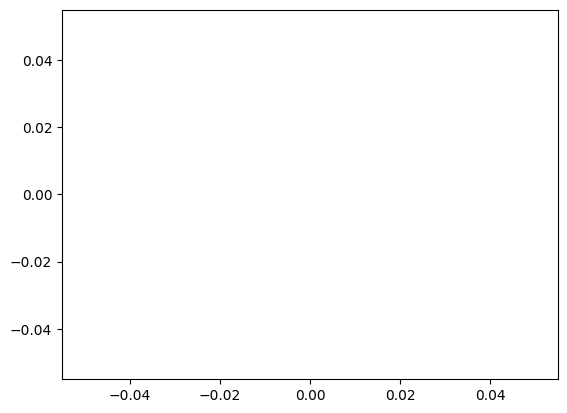

In [4]:
# Import Holomonitor
holo_dir = ["../../data/Holomonitor/MDCK_01.03.2024/",
            "../../data/Holomonitor/MDCK_19.03.2024/",
            "../../data/Holomonitor/MDCK_16.05.2024/"]

holo_files = ["B2-5", "A1-9", "A1-12", "A1-18", "B1-11", "B1-9"]
holo_paths = [holo_dir[0], holo_dir[1], holo_dir[1], holo_dir[1], holo_dir[1], holo_dir[2]]

# Import Tomocube
tomo_files = ["250210.113448.MDCK dynamics.001.MDCK B.A2"]
tomo_paths  = ["../../data/Tomocube/MDCK_10.02.2025/A2P1/"]

holo_colors = cm.devon(np.linspace(0,0.6,3))
tomo_colors = cm.lajolla(np.linspace(0.2,0.8,3))

h0, = plt.plot([0], marker='None', linestyle='None', label='dummy-tophead');

In [25]:
# Holomonitor
# settings
fluct_pixel = np.zeros(len(holo_paths))
fluct_disk  = np.zeros(len(holo_paths))
fluct_cell  = np.zeros(len(holo_paths))
nfluct_cell = np.zeros(len(holo_paths))

err_fluct_pixel = np.zeros(len(holo_paths))
err_fluct_disk  = np.zeros(len(holo_paths))
err_fluct_cell  = np.zeros(len(holo_paths))
err_nfluct_cell = np.zeros(len(holo_paths))

N_cells = np.zeros([len(holo_paths)])

i = 0
for path, file in zip(holo_paths[1:], holo_files[1:]):
    # import data
    h_holo  = import_holomonitor_stack(path, file, f_min=fmin_holo[i], f_max=fmax_holo[i])
    df_holo = pd.read_csv(f"{path}{file}/area_volume_filtered.csv")

    # disk wise data
    hblur_holo = np.zeros_like(h_holo)
    for frame in range(len(h_holo)):
        r_cell = average_cell_radius(df_holo, frame, pix_to_um, blur_factor=rblur_holo)
        hblur_holo[frame] = gaussian_filter(h_holo[frame], r_cell)

    # Cell wise data
    tracks_raw = tp.link(df_holo, search_range=10, memory=5)
    tracks     = tp.filter_stubs(tracks_raw, 10)

    # Compute fluctuation
    _, fluct_pixel_tmp = compute_temporal_fluctuations(h_holo, df_holo, len(h_holo), 1, 1)
    _, fluct_disk_tmp  = compute_temporal_fluctuations(hblur_holo[:,r_cell:-r_cell,r_cell:-r_cell], df_holo, len(h_holo), 1, 1)
    N_cells[i], fluct_cell_tmp, nfluct_cell_tmp = compute_temporal_fluctuations_cellwise_entire_stack(tracks)

    fluct_pixel[i]  = np.mean(fluct_pixel_tmp)
    fluct_disk[i]   = np.mean(fluct_disk_tmp)
    fluct_cell[i]   = np.mean(fluct_cell_tmp)
    nfluct_cell[i]  = np.mean(nfluct_cell_tmp)

    err_fluct_pixel[i]  = np.std(fluct_pixel_tmp) / np.sqrt(len(fluct_pixel_tmp))
    err_fluct_disk[i]   = np.std(fluct_disk_tmp)  / np.sqrt(len(fluct_disk_tmp))
    err_fluct_cell[i]   = np.std(fluct_cell_tmp)  / np.sqrt(len(fluct_cell_tmp))
    err_nfluct_cell[i]  = np.std(nfluct_cell_tmp)  / np.sqrt(len(nfluct_cell_tmp))

    i += 1

Frame 144: 786 trajectories present.


/home/silja/Programs/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/silja/Programs/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/silja/Programs/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/silja/Programs/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/silja/Programs/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [26]:
for i in range(len(holo_files)):
    print(f"Relative error:\nPixel wise ({fluct_pixel[i]*100:0.3f} ± {err_fluct_pixel[i]*100:0.3f})%")
    print(f"Disk wise  ({fluct_disk[i]*100:0.3f} ± {err_fluct_disk[i]*100:0.3f})%")
    print(f"Cell wise  ({fluct_cell[i]*100:0.1f} ± {err_fluct_cell[i]*100:0.1f})%\n")

Relative error:
Pixel wise (33.769 ± 0.008)%
Disk wise  (22.175 ± 0.007)%
Cell wise  (13.0 ± 0.1)%

Relative error:
Pixel wise (31.841 ± 0.006)%
Disk wise  (20.607 ± 0.005)%
Cell wise  (12.6 ± 0.1)%

Relative error:
Pixel wise (31.495 ± 0.010)%
Disk wise  (18.804 ± 0.008)%
Cell wise  (13.8 ± 0.2)%

Relative error:
Pixel wise (34.556 ± 0.009)%
Disk wise  (21.054 ± 0.006)%
Cell wise  (14.1 ± 0.2)%

Relative error:
Pixel wise (31.379 ± 0.008)%
Disk wise  (23.152 ± 0.006)%
Cell wise  (14.8 ± 0.2)%

Relative error:
Pixel wise (0.000 ± 0.000)%
Disk wise  (0.000 ± 0.000)%
Cell wise  (0.0 ± 0.0)%



In [ ]:
# Tomocube
# settings
fluct_pixel = np.zeros(len(tomo_paths))
fluct_disk  = np.zeros(len(tomo_paths))
fluct_cell  = np.zeros(len(tomo_paths))
nfluct_cell = np.zeros(len(tomo_paths))

err_fluct_pixel = np.zeros(len(tomo_paths))
err_fluct_disk  = np.zeros(len(tomo_paths))
err_fluct_cell  = np.zeros(len(tomo_paths))
err_nfluct_cell = np.zeros(len(tomo_paths))

N_cells = np.zeros([len(tomo_paths)])

i = 0
for path, file in zip(tomo_paths, tomo_files):
    # import data
    _, h_tomo = import_tomocube_stack(path, file, f_min=fmin_tomo, f_max=fmax_tomo, h_scaling=vox_to_um[0])
    df_tomo = pd.read_csv(f"{path}/area_volume_filtered.csv")

    # disk wise data
    hblur_tomo = np.zeros_like(h_tomo)
    for frame in range(len(h_tomo)):
        r_cell = average_cell_radius(df_tomo, frame, vox_to_um, blur_factor=rblur_tomo)

        # avoid empty regions
        # n_tmp = np.copy(h_tomo[frame])
        # n_tmp[n_tmp == 0] = 1.38
        # hblur_tomo[frame] = gaussian_filter(n_tmp, r_cell)
        hblur_tomo[frame] = gaussian_filter(h_tomo[frame], r_cell)

    # Cell wise data
    tracks_raw = tp.link(df_tomo, search_range=50, memory=5)
    tracks     = tp.filter_stubs(tracks_raw, 20)

    # Compute fluctuation
    _, fluct_pixel_tmp = compute_temporal_fluctuations(h_tomo, df_tomo, len(h_tomo), 1, 1)
    _, fluct_disk_tmp  = compute_temporal_fluctuations(hblur_tomo[:,r_cell:-r_cell,r_cell:-r_cell], df_tomo, len(h_tomo), 1, 1)
    N_cells[i], _, fluct_cell_tmp = compute_temporal_fluctuations_cellwise_entire_stack(tracks)

    fluct_pixel[i]  = np.mean(fluct_pixel_tmp)
    fluct_disk[i]   = np.mean(fluct_disk_tmp)
    fluct_cell[i]   = np.mean(fluct_cell_tmp)
    
    err_fluct_pixel[i]  = np.std(fluct_pixel_tmp) / np.sqrt(len(fluct_pixel_tmp))
    err_fluct_disk[i]   = np.std(fluct_disk_tmp)  / np.sqrt(len(fluct_disk_tmp))
    err_fluct_cell[i]   = np.std(fluct_cell_tmp)  / np.sqrt(len(fluct_cell_tmp))

    i += 1

KeyboardInterrupt: 

In [ ]:
for i in range(len(tomo_files)):
    print(f"Relative error:\nPixel wise ({fluct_pixel[i]*100:0.5f} ± {err_fluct_pixel[i]*100:0.5f})%")
    print(f"Disk wise  ({fluct_disk[i]*100:0.5f} ± {err_fluct_disk[i]*100:0.5f})%")
    print(f"Cell wise  ({fluct_cell[i]*100:0.3f} ± {err_fluct_cell[i]*100:0.3f})%\n")

In [16]:
# Holomonitor
# settings
stepsize = int(dt_holo / 2)
steps = int(np.ceil((np.max(fmax_holo) - np.min(fmin_holo) + 1 - dt*dt_holo) / stepsize))

density_pix  = []
density_disk = []
density_cell = []

fluctuation_pixel = []
fluctuation_disk  = []
fluctuation_cell  = []
nfluctuation_cell = []

N_cells = np.zeros([len(holo_paths), steps])

i = 0
for path, file in zip(holo_paths[1:], holo_files[1:]):
    steps = int(np.ceil((fmax_holo[i] - fmin_holo[i] + 1 - dt*dt_holo) / stepsize))

    # import data
    h_holo  = import_holomonitor_stack(path, file, f_min=fmin_holo[i], f_max=fmax_holo[i])
    df_holo = pd.read_csv(f"{path}{file}/area_volume_filtered.csv")

    # disk wise data
    hblur_holo = np.zeros_like(h_holo)
    for frame in range(fmax_holo[i]-fmin_holo[i]+1):
        r_cell = average_cell_radius(df_holo, frame, pix_to_um, blur_factor=rblur_holo)
        hblur_holo[frame] = gaussian_filter(h_holo[frame], r_cell)

    # Cell wise data
    tracks_raw = tp.link(df_holo, search_range=10, memory=5)
    tracks     = tp.filter_stubs(tracks_raw, 5)

    # Compute fluctuation
    density_pix_tmp,  fluct_pixel_tmp = compute_temporal_fluctuations(h_holo, df_holo, dt*dt_holo, steps, stepsize)
    density_disk_tmp, fluct_disk_tmp  = compute_temporal_fluctuations(hblur_holo[:,r_cell:-r_cell,r_cell:-r_cell], df_holo, dt*dt_holo, steps, stepsize)
    density_cell_tmp, fluct_cell_tmp, _ = compute_temporal_fluctuations_cellwise(tracks, dt*dt_holo, steps, stepsize)

    density_pix.append(density_pix_tmp)
    density_disk.append(density_disk_tmp)
    density_cell.append(density_cell_tmp)
    fluctuation_pixel.append(fluct_pixel_tmp)
    fluctuation_disk.append(fluct_disk_tmp)
    fluctuation_cell.append(fluct_cell_tmp)
    

    i += 1

Frame 144: 786 trajectories present.


In [17]:
density_pix  = np.concatenate(density_pix)
density_disk = np.concatenate(density_disk)
density_cell = np.concatenate(density_cell)
fluct_pix  = np.concatenate(fluctuation_pixel)
fluct_disk = np.concatenate(fluctuation_disk)
fluct_cell = np.concatenate(fluctuation_cell)

bin_size = 100
density_min = 1600
density_max = 2600
n_bins = int((density_max - density_min) / bin_size)

h_binned_density = np.zeros(n_bins)
h_mean_pixel, std_pixel = np.zeros(n_bins), np.zeros(n_bins)
h_mean_disk,  std_disk  = np.zeros(n_bins), np.zeros(n_bins)
h_mean_cell,  std_cell  = np.zeros(n_bins), np.zeros(n_bins)


for i in range(n_bins):
    mask_pix  = (density_pix  >= density_min + i*bin_size) * (density_pix  < density_min + (i+1)*bin_size)
    mask_disk = (density_disk >= density_min + i*bin_size) * (density_disk < density_min + (i+1)*bin_size)
    mask_cell = (density_cell >= density_min + i*bin_size) * (density_cell < density_min + (i+1)*bin_size)
    h_binned_density[i] = np.mean(density_pix[mask_pix])
        
    h_mean_pixel[i] = np.mean(fluct_pix[mask_pix])  *100
    h_mean_disk[i]  = np.mean(fluct_disk[mask_disk])*100
    h_mean_cell[i]  = np.mean(fluct_cell[mask_cell])*100

    std_pixel[i]  = np.std(fluct_pix[mask_pix],   ddof=1)*100 / np.sqrt(np.sum(mask_pix))
    std_disk[i]   = np.std(fluct_disk[mask_disk], ddof=1)*100 / np.sqrt(np.sum(mask_disk))
    std_cell[i]   = np.std(fluct_cell[mask_cell], ddof=1)*100 / np.sqrt(np.sum(mask_cell))

In [22]:
for i in range(len(holo_files)-1):
    print(f"Relative error:\nPixel wise ({np.mean(fluctuation_pixel[i])*100:0.3f} ± {np.std(fluctuation_pixel[i])*100 / np.sqrt(len(fluctuation_pixel[i])):0.3f})%")
    print(f"Disk wise  ({np.mean(fluctuation_disk[i])*100:0.3f} ± {np.std(fluctuation_disk[i])*100 / np.sqrt(len(fluctuation_disk[i])):0.3f})%")
    print(f"Cell wise  ({np.mean(fluctuation_cell[i])*100:0.1f} ± {np.std(fluctuation_cell[i])*100 / np.sqrt(len(fluctuation_cell[i])):0.1f})%\n")

Relative error:
Pixel wise (27.623 ± 0.002)%
Disk wise  (15.190 ± 0.001)%
Cell wise  (12.9 ± 0.1)%

Relative error:
Pixel wise (26.506 ± 0.002)%
Disk wise  (14.878 ± 0.001)%
Cell wise  (12.8 ± 0.1)%

Relative error:
Pixel wise (31.127 ± 0.010)%
Disk wise  (18.335 ± 0.008)%
Cell wise  (16.4 ± 0.5)%

Relative error:
Pixel wise (28.829 ± 0.002)%
Disk wise  (15.781 ± 0.002)%
Cell wise  (14.4 ± 0.1)%

Relative error:
Pixel wise (23.531 ± 0.002)%
Disk wise  (14.827 ± 0.002)%
Cell wise  (13.9 ± 0.1)%



In [8]:
# Tomocube
# settings
stepsize = int(dt_tomo / 2)
steps = int(np.ceil((np.max(fmax_tomo) - np.min(fmin_tomo) + 1 - dt*dt_tomo) / stepsize))

density_pix  = []
density_disk = []
density_cell = []

fluctuation_pixel = []
fluctuation_disk  = []
fluctuation_cell  = []
nfluctuation_cell = []

i = 0
for path, file in zip(tomo_paths, tomo_files):
    steps = int(np.ceil((fmax_tomo - fmin_tomo + 1 - dt*dt_tomo) / stepsize))

    # import data
    _, h_tomo = import_tomocube_stack(path, file, f_min=fmin_tomo, f_max=fmax_tomo, h_scaling=vox_to_um[0])
    df_tomo = pd.read_csv(f"{path}/area_volume_filtered.csv")

    # disk wise data
    hblur_tomo = np.zeros_like(h_tomo)
    for frame in range(fmax_tomo-fmin_tomo+1):
        r_cell = average_cell_radius(df_tomo, frame, vox_to_um, blur_factor=rblur_tomo)
        hblur_tomo[frame] = gaussian_filter(h_tomo[frame], r_cell)

    # Cell wise data
    tracks_raw = tp.link(df_tomo, search_range=50, memory=5)
    tracks     = tp.filter_stubs(tracks_raw, 10)

    # Compute fluctuation
    density_pix_tmp,  fluct_pixel_tmp = compute_temporal_fluctuations(h_tomo, df_tomo, dt*dt_tomo, steps, stepsize)
    density_disk_tmp, fluct_disk_tmp  = compute_temporal_fluctuations(hblur_tomo[:,r_cell:-r_cell,r_cell:-r_cell], df_tomo, dt*dt_tomo, steps, stepsize)
    density_cell_tmp, fluct_cell_tmp, _ = compute_temporal_fluctuations_cellwise(tracks, dt*dt_tomo, steps, stepsize)

    density_pix.append(density_pix_tmp)
    density_disk.append(density_disk_tmp)
    density_cell.append(density_cell_tmp)
    fluctuation_pixel.append(fluct_pixel_tmp)
    fluctuation_disk.append(fluct_disk_tmp)
    fluctuation_cell.append(fluct_cell_tmp)
    
    i += 1

Frame 39: 989 trajectories present.


In [9]:
density_pix  = np.concatenate(density_pix)
density_disk = np.concatenate(density_disk)
density_cell = np.concatenate(density_cell)
fluct_pix  = np.concatenate(fluctuation_pixel)
fluct_disk = np.concatenate(fluctuation_disk)
fluct_cell = np.concatenate(fluctuation_cell)

bin_size = 100
density_min = 2400
density_max = 3600
n_bins = int((density_max - density_min) / bin_size)

t_binned_density = np.zeros(n_bins)
t_mean_pixel, std_pixel = np.zeros(n_bins), np.zeros(n_bins)
t_mean_disk,  std_disk  = np.zeros(n_bins), np.zeros(n_bins)
t_mean_cell,  std_cell  = np.zeros(n_bins), np.zeros(n_bins)


for i in range(n_bins):
    mask_pix  = (density_pix  >= density_min + i*bin_size) * (density_pix  < density_min + (i+1)*bin_size)
    mask_disk = (density_disk >= density_min + i*bin_size) * (density_disk < density_min + (i+1)*bin_size)
    mask_cell = (density_cell >= density_min + i*bin_size) * (density_cell < density_min + (i+1)*bin_size)
    t_binned_density[i] = np.mean(density_pix[mask_pix])
        
    t_mean_pixel[i] = np.mean(fluct_pix[mask_pix])  *100
    t_mean_disk[i]  = np.mean(fluct_disk[mask_disk])*100
    t_mean_cell[i]  = np.mean(fluct_cell[mask_cell])*100

    std_pixel[i]  = np.std(fluct_pix[mask_pix],   ddof=1)*100 / np.sqrt(np.sum(mask_pix))
    std_disk[i]   = np.std(fluct_disk[mask_disk], ddof=1)*100 / np.sqrt(np.sum(mask_disk))
    std_cell[i]   = np.std(fluct_cell[mask_cell], ddof=1)*100 / np.sqrt(np.sum(mask_cell))

/home/silja/Programs/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/silja/Programs/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/silja/Programs/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/silja/Programs/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/silja/Programs/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/silja/Programs/miniconda3/lib/python3.10/site-packages/n

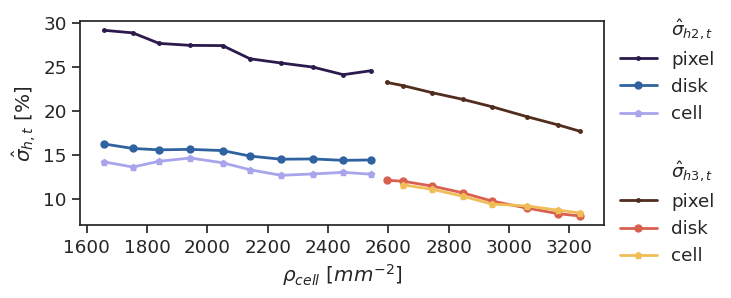

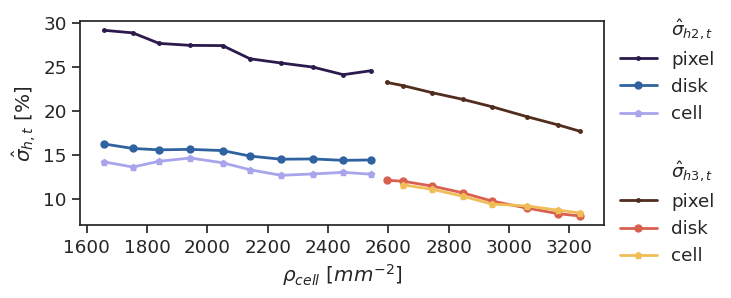

In [11]:
lw = 2
ms = 5

fig, ax = plt.subplots(1,1, figsize=(7.5,3), sharey=False)
sns.set_theme(style='ticks', palette='dark', font_scale=1.2)

ax.set(xlabel=r"$\rho_{cell} ~[mm^{-2}]$", ylabel=r"$\hat{\sigma}_{h,t} ~[\%] $")

h2_1=ax.plot(h_binned_density, h_mean_pixel, ".-", lw=lw, ms=ms, label="pixel", color=holo_colors[0])
h2_2=ax.plot(h_binned_density, h_mean_disk,  "o-", lw=lw, ms=ms, label="disk",  color=holo_colors[1])
h2_3=ax.plot(h_binned_density, h_mean_cell,  "p-", lw=lw, ms=ms, label="cell",  color=holo_colors[2])

h3_1=ax.plot(t_binned_density, t_mean_pixel, ".-", lw=lw, ms=ms, label="pixel", color=tomo_colors[0])
h3_2=ax.plot(t_binned_density, t_mean_disk,  "o-", lw=lw, ms=ms, label="disk",  color=tomo_colors[1])
h3_3=ax.plot(t_binned_density, t_mean_cell,  "p-", lw=lw, ms=ms, label="cell",  color=tomo_colors[2])

fig.tight_layout(rect=[0, 0, 0.85, 1.05])

ax.legend([h0, h2_1[0], h2_2[0], h2_3[0], h0, h0, h3_1[0], h3_2[0], h3_3[0]],
          [r'$\hat{\sigma}_{h2,t}$', 'pixel', 'disk', 'cell', '', r'$\hat{\sigma}_{h3,t}$', 'pixel', 'disk', 'cell'],
           loc='upper center',
           bbox_to_anchor=(1.12, 1.1),
           frameon=False,
           alignment='center')

fig.savefig(f"../../figs/flatness/temporal_height_variation.png", dpi=300)

In [ ]:
# illustration
n_im = n_im[:,1000:2000, 1000:2000]
h_im = h_im[:,1000:2000, 1000:2000]

h_data = []
n_data = []
for f in range(f_f+1):
    r_cell = typical_radius(cell_df, f, vox_to_um[1]**2)
    if f == 0:
        print(r_cell)
    elif f==f_f:
        print(r_cell)    
    h_blur = uniform_filter(h_im[f], r_cell)
    n_blur = uniform_filter(n_im[f], r_cell)
    h_data.append(h_blur)
    n_data.append(n_blur)
h_blur = np.array(h_data, dtype=np.float32) * vox_to_um[0]
n_blur = scale_refractive(np.array(n_data))

107
89


In [ ]:
tracks_raw = tp.link(cell_df, search_range=50, memory=5)
tracks     = tp.filter_stubs(tracks_raw, 5)
in_frame_i = tracks[(tracks.frame==0)*(tracks.x < 2000)*(tracks.x > 1000)*(tracks.y < 2000)*(tracks.y > 1000)].particle.values
in_frame_f = tracks[(tracks.frame==40)*(tracks.x < 2000)*(tracks.x > 1000)*(tracks.y < 2000)*(tracks.y > 1000)].particle.values

in_both = np.intersect1d(in_frame_i, in_frame_f)
in_both
r_min = 89
r_max = 107

89+107

Frame 40: 993 trajectories present.


196

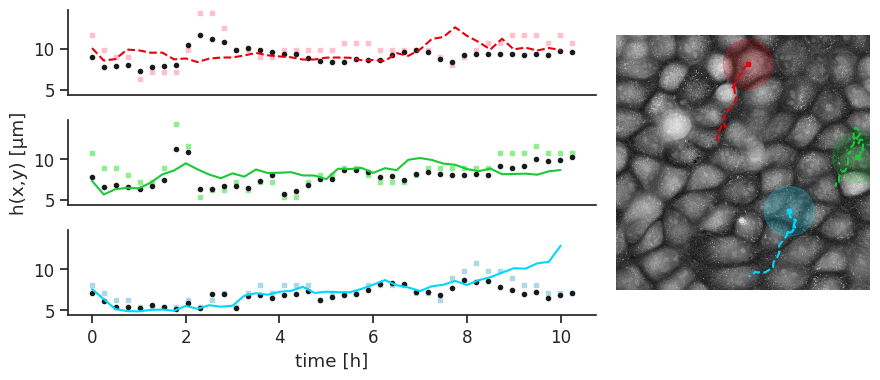

In [ ]:
# Define the GridSpec layout
# plot cell path and disk radius
gs = gridspec.GridSpec(6, 18)

fig = plt.figure(figsize=(9, 4))
sns.set_theme(style='ticks', palette='bright', font_scale=1.1)

im = fig.add_subplot(gs[0:6, 12:18])
h0 = fig.add_subplot(gs[:2, :12])
h1 = fig.add_subplot(gs[2:4, :12], sharey=h0)
h2 = fig.add_subplot(gs[4:, :12], sharey=h0)

sns.heatmap(n_im[0], ax=im, square=True, cmap="gray", xticklabels=False, yticklabels=False, cbar=False)
time = np.linspace(0, len(h_im), len(h_im)) * 1/4

i = 7
x = tracks[tracks.particle == in_both[i]].x.values[0]-1000
y = tracks[tracks.particle == in_both[i]].y.values[0]-1000
h0.plot(time, h_im[:,x,y]*vox_to_um[0], 's', color='pink', ms=3)
h0.plot(time, h_blur[:,x,y]*vox_to_um[0], 'k.')
h0.plot(tracks[tracks.particle==in_both[i]].frame / 4, tracks[tracks.particle==in_both[i]].h_avrg, 'r--')
disk=plt.Circle((x, y), 98, color='r', alpha=0.2)
im.add_patch(disk)
im.plot(x,y, 'rs', ms=3)
im.plot(tracks[tracks.particle == in_both[i]].x.values-1000, tracks[tracks.particle == in_both[i]].y.values-1000, 'r--')

i = 1
x = tracks[tracks.particle == in_both[i]].x.values[0]-1000
y = tracks[tracks.particle == in_both[i]].y.values[0]-1000
h1.plot(time, h_im[:,x,y]*vox_to_um[0], 's', color='lightgreen', ms=3)
h1.plot(time, h_blur[:,x,y]*vox_to_um[0], 'k.')
h1.plot( tracks[tracks.particle==in_both[i]].frame / 4, tracks[tracks.particle==in_both[i]].h_avrg, 'g-')
disk=plt.Circle((x, y), 98, color='g', alpha=0.2)
im.add_patch(disk)
im.plot(x,y, 'gs', ms=3)
im.plot(tracks[tracks.particle == in_both[i]].x.values-1000, tracks[tracks.particle == in_both[i]].y.values-1000, 'g--')

i = 4
x = tracks[tracks.particle == in_both[i]].x.values[0]-1000
y = tracks[tracks.particle == in_both[i]].y.values[0]-1000
h2.plot(time, h_im[:,x,y]*vox_to_um[0], 's', color="lightblue", ms=3)
h2.plot(time, h_blur[:,x,y]*vox_to_um[0], 'k.')
h2.plot(tracks[tracks.particle==in_both[i]].frame /4, tracks[tracks.particle==in_both[i]].h_avrg, 'c-')
disk=plt.Circle((x, y), 98, color='c', alpha=0.2)
im.add_patch(disk)
im.plot(x,y, 'cs', ms=3)
im.plot(tracks[tracks.particle == in_both[i]].x.values-1000, tracks[tracks.particle == in_both[i]].y.values-1000, 'c--')

h2.set(xlabel="time [h]")
h1.set(ylabel="h(x,y) [µm]")
h1.set_xticks([])
h0.set_xticks([])
sns.despine(ax=h0)
sns.despine(ax=h1)
sns.despine(ax=h2)
fig.tight_layout()

In [ ]:
fig.savefig("../Figures/fluctuations/h_compare_pixel_disk_cell.png")